In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from myutils.nerdssData import nerdssData
from myutils.process_AD import readResT_from_NERDSS
from myutils.utils import find_equi_linear

In [3]:
def readGillespieSurvP(filename):
    # No estimation of standard error since it is a single experiment
    with open(filename) as f:
        reading = False
        times = []
        survP = []
        numDiss = 'Not Read'
        for line in f:
            if line.strip() == '# START SURVIVAL PROB':
                reading = True
            elif line.strip() == '# END SURVIVAL PROB':
                reading = False
            elif line.strip() == '# Mean Residence Time':
                meanResT = float(f.readline().strip())
            elif line.strip().startswith('Number of dissociation events:'):
                numDiss = int(line.split(':')[1])
            else:
                if reading:
                    linelist = line.split()
                    times.append(float(linelist[0]))
                    survP.append(float(linelist[1]))
    return np.array(times), np.array(survP), meanResT, numDiss

def get_survival_prob(resident_times, bins=100):

    # get survival probabilities
    h = np.histogram(resident_times, bins=bins, density=True)
    return h[1], np.append([1], 1 - np.cumsum(h[0]*np.diff(h[1])))

def bootstrapSurvProb(resTime_nerdss, tbins, N_batch=100):
    N_sample = len(resTime_nerdss)
    # print(N_sample, batchSize)
    survprobList = []
    for _ in range(N_batch):
        randomIDs = np.random.choice(np.arange(0,N_sample,1), size=N_sample, replace=True)
        randomChoices = []
        for i in randomIDs:
            randomChoices.append(resTime_nerdss[i])
        time, survP = get_survival_prob(np.concatenate(randomChoices), tbins)
        survprobList.append(survP)
    return time, survprobList

In [4]:
pfolder_NERDSS = './Simulations/NERDSS_monomer/'
pfolder_Gillespie = './Simulations/NERDSS_monomer/Gillespie/'

In [100]:
def compareNerdssWithGillespie(
    dt, folders, NerdssRepeatIDs, startT=10, binwidth=0.05, timeUpperLimit=1000, ifplot=True,
):
    results = []
    for j, pfolder in enumerate(folders):
        # read and process survival probability from gillespie
        gllspFile = pfolder_Gillespie+f'/out_{j}_r0'
        timeGllsp, survPGllsp, meanRestGllsp, numEvents = readGillespieSurvP(gllspFile)
        
        # read residence times from NERDSS kinetics
        resTime_nerdss = []
        resTime_means = []
        for i in NerdssRepeatIDs:
            jobfolder = pfolder_NERDSS+f'/{pfolder}/SIMS/{i}/'
            resTi, _ = readResT_from_NERDSS(
                jobfolder+'/DATA/assoc_dissoc_time.dat', dt, startT=startT
            )
            resTime_nerdss.append(resTi)
            resTime_means.append(np.mean(resTi))
            
        if ifplot:
            # get survival probability from NERDSS residence times
            timeNERDSS, survprobList = bootstrapSurvProb(resTime_nerdss, np.arange(0, timeUpperLimit, binwidth))
            survP_mean = np.mean(survprobList, axis=0)
            survP_std = np.std(survprobList, axis=0)
            survpFilter = survP_mean>1e-3

            # plot
            # setup figure properties
            fig = plt.figure(figsize=(5,5))
            ax = fig.add_subplot(111)
            plt.tick_params(length=15, width=2)
            for axis in ['top', 'bottom', 'left', 'right']:
                ax.spines[axis].set_linewidth(2)  # change width
            # nerdss result with +- error
            plt.fill_between(
                timeNERDSS[survpFilter], 
                survP_mean[survpFilter] - 1*survP_std[survpFilter], 
                survP_mean[survpFilter] + 1*survP_std[survpFilter], 
                label='NERDSS', alpha=0.5
            )
            # gillespie results
            plt.plot(
                timeGllsp[survPGllsp>1e-3], survPGllsp[survPGllsp>1e-3], 
                label='Gillespie', color='black', lw=1.5
            )   

            plt.semilogy()

            plt.xlim([0, min(timeGllsp[survPGllsp>1e-3][-1], timeNERDSS[survpFilter][-1])])
            plt.ylim([1e-3,1e0])
            plt.xticks(fontsize=22)
            plt.yticks(fontsize=22)
            
            plt.legend(fontsize=14)

            plt.show()

        results.append([
            meanRestGllsp, 
            np.mean(resTime_means), 
            np.std(resTime_means)/np.sqrt(len(resTime_means))
        ])
        
    return np.array(results)

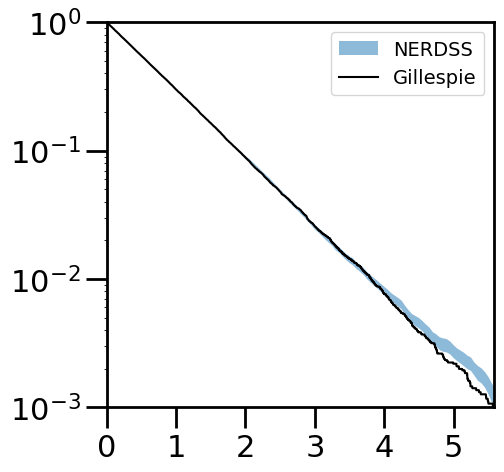

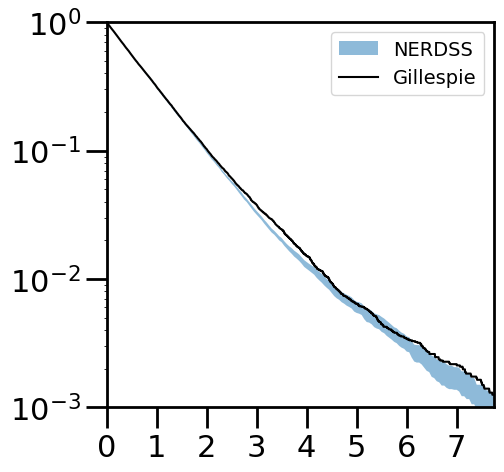

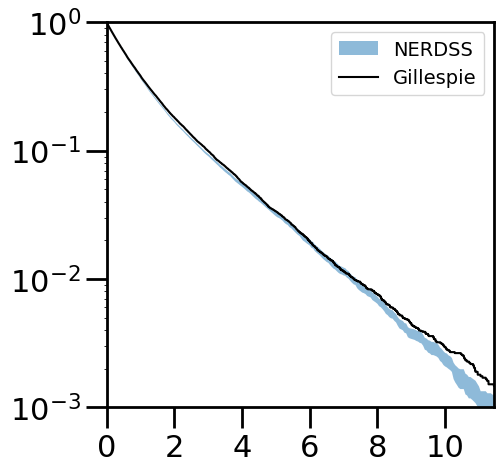

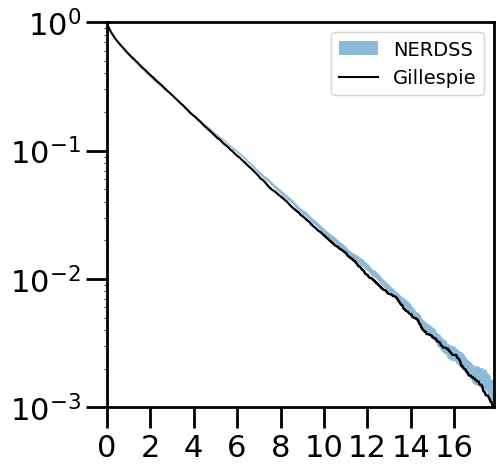

In [101]:
foldersNerdss = ['kpp0', 'kppE2',  'kppE3', 'kppE4']
NerdssRepeatIDs = [i for i in range(1,49)]
resTcompare = compareNerdssWithGillespie(
    1e-6, foldersNerdss, NerdssRepeatIDs, startT=30, ifplot=True
)

In [7]:
resTcompare

array([[0.82862   , 0.8259193 , 0.00501351],
       [0.88638   , 0.86949161, 0.00597456],
       [1.2137    , 1.16765015, 0.01107617],
       [2.2778    , 2.28092929, 0.01988233]])

In [19]:
species = ['P: 1.', 'P: 2.', 'P: 1. N: 1.', 'P: 2. N: 1.', 'P: 2. N: 2.']
nerdss_jobs = ['kpp0', 'kppE2', 'kppE3', 'kppE4']

In [89]:
nerdss.parms.WBvol*10

10500148.354500001

In [21]:
NerdssRepeatIDs = [i for i in range(1,49)]
EQUI_mean = []
EQUI_err = []
for job in nerdss_jobs:
    nerdss = nerdssData(NerdssRepeatIDs, pfolder_NERDSS+'/'+job+'/SIMS')
    nerdss.readHist(dataHist='DATA/histogram_complexes_time.dat', ifprint=False)
    mean_list = []
    err_list = []
    for s in species:
        print(s)
        if s not in nerdss.MOLS:
            mean_list.append(0)
            err_list.append(0)
        else:
            windowsize, _, mean,std = find_equi_linear(nerdss.time, nerdss.MOLS[s], ifdraw=False)
            error = np.sqrt(std**2 / windowsize + np.mean(nerdss.MOLS_err[s][-windowsize:])**2)
            mean_list.append(mean)
            err_list.append(error)
    EQUI_mean.append(mean_list)
    EQUI_err.append(err_list)

100% (315 of 315) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 314 Elapsed Time: 0:00:00
100% (315 of 315) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
/ |#                                                  | 0 Elapsed Time: 0:00:00

>>>>>> parsing ./Simulations/NERDSS_monomer//kpp0/SIMS
WaterBox = [1050.0, 31.623, 31.623] # VtoL=4000
{'P': 20, 'N': 600}
Reactions:
N(bs) + P(dbn) <-> N(bs!1).P(dbn!1)
P(dmr) + P(dmr) <-> P(dmr!1).P(dmr!1)
<<<<<< finished parsing
------------------------------------------------------
P: 1.
Steady state found
P: 2.
P: 1. N: 1.


| |#                                                | 302 Elapsed Time: 0:00:00
100% (308 of 308) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 307 Elapsed Time: 0:00:00
100% (308 of 308) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 248 Elapsed Time: 0:00:00
  0% (0 of 308) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Steady state found
P: 2. N: 1.
P: 2. N: 2.
>>>>>> parsing ./Simulations/NERDSS_monomer//kppE2/SIMS
WaterBox = [1050.0, 31.623, 31.623] # VtoL=4000
{'P': 20, 'N': 600}
Reactions:
N(bs) + P(dbn) <-> N(bs!1).P(dbn!1)
P(dmr) + P(dmr) <-> P(dmr!1).P(dmr!1)
<<<<<< finished parsing
------------------------------------------------------
P: 1.
Steady state found
P: 2.
Steady state found
This state has avearage = 0.05 -> 0. Please BE CAREFUL that this is special!
P: 1. N: 1.


100% (308 of 308) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 303 Elapsed Time: 0:00:00
100% (308 of 308) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 241 Elapsed Time: 0:00:00
100% (308 of 308) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 238 Elapsed Time: 0:00:00
  0% (0 of 322) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Steady state found
P: 2. N: 1.
Steady state found
This state has avearage = 0.01 -> 0. Please BE CAREFUL that this is special!
P: 2. N: 2.
Steady state found
This state has avearage = 0.04 -> 0. Please BE CAREFUL that this is special!
>>>>>> parsing ./Simulations/NERDSS_monomer//kppE3/SIMS
WaterBox = [1050.0, 31.623, 31.623] # VtoL=4000
{'P': 20, 'N': 600}
Reactions:
N(bs) + P(dbn) <-> N(bs!1).P(dbn!1)
P(dmr) + P(dmr) <-> P(dmr!1).P(dmr!1)
<<<<<< finished parsing
------------------------------------------------------
P: 1.


100% (322 of 322) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 321 Elapsed Time: 0:00:00
100% (322 of 322) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 315 Elapsed Time: 0:00:00
100% (322 of 322) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 318 Elapsed Time: 0:00:00
  0% (0 of 322) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Steady state found
P: 2.
Steady state found
This state has avearage = 0.42 -> 0. Please BE CAREFUL that this is special!
P: 1. N: 1.
Steady state found
P: 2. N: 1.


100% (322 of 322) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 304 Elapsed Time: 0:00:00
100% (322 of 322) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 297 Elapsed Time: 0:00:00
100% (323 of 323) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
/ |#                                                  | 0 Elapsed Time: 0:00:00

Steady state found
This state has avearage = 0.07 -> 0. Please BE CAREFUL that this is special!
P: 2. N: 2.
Steady state found
This state has avearage = 0.36 -> 0. Please BE CAREFUL that this is special!
>>>>>> parsing ./Simulations/NERDSS_monomer//kppE4/SIMS
WaterBox = [1050.0, 31.623, 31.623] # VtoL=4000
{'P': 20, 'N': 600}
Reactions:
N(bs) + P(dbn) <-> N(bs!1).P(dbn!1)
P(dmr) + P(dmr) <-> P(dmr!1).P(dmr!1)
<<<<<< finished parsing
------------------------------------------------------
P: 1.


| |#                                                | 322 Elapsed Time: 0:00:00
100% (323 of 323) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 322 Elapsed Time: 0:00:00
100% (323 of 323) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 318 Elapsed Time: 0:00:00
  0% (0 of 323) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Steady state found
P: 2.
Steady state found
P: 1. N: 1.
Steady state found
P: 2. N: 1.


100% (323 of 323) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 309 Elapsed Time: 0:00:00
100% (323 of 323) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
| |#                                                | 317 Elapsed Time: 0:00:00


Steady state found
This state has avearage = 0.30 -> 0. Please BE CAREFUL that this is special!
P: 2. N: 2.
Steady state found


In [93]:
volume = 10500148.354500001

# NERDSS data - now with 5 measurements per condition
NERDSS_copynumbers = np.array(EQUI_mean)*10 / volume / 0.6022 * 1e6
NERDSS_copynumber_errors = np.array(EQUI_err)*10 / volume / 0.6022 * 1e6

# Gillespie data
# Format: [P, PP, PN, PPN, PNPN] for each condition
true_copynumbers = np.array([
    [183, 0,  17, 0, 0],    # Condition 1: P, PP, PN, PPN, PNPN
    [181, 1,  17, 0, 0],   # Condition 2: P, PP, PN, PPN, PNPN
    [166, 4,  16, 1, 4],      # Condition 3: P, PP, PN, PPN, PNPN
    [110, 19, 10, 4, 17]   # Condition 4: P, PP, PN, PPN, PNPN
]) / volume / 0.6022 * 1e6
Gillespie_dwelltime = resTcompare[:,0]

# NERDSS data
NERDSS_dwelltime = resTcompare[:,1]
NERDSS_dwelltime_errors = resTcompare[:,2]

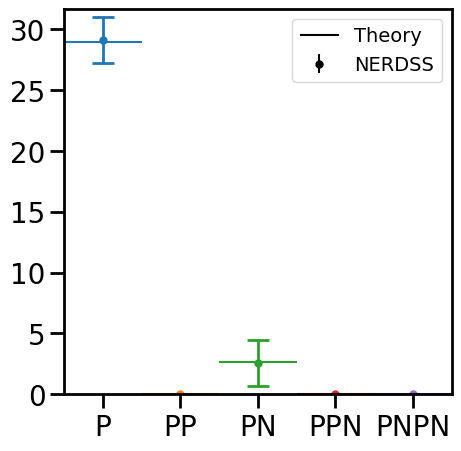

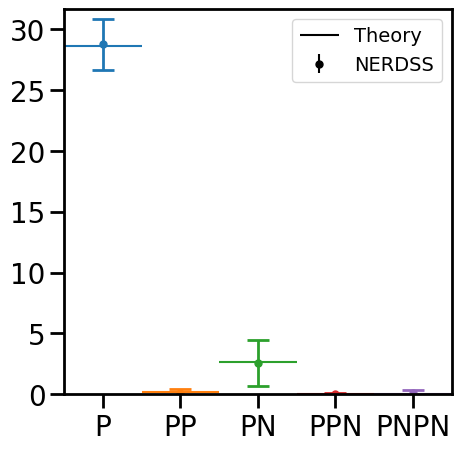

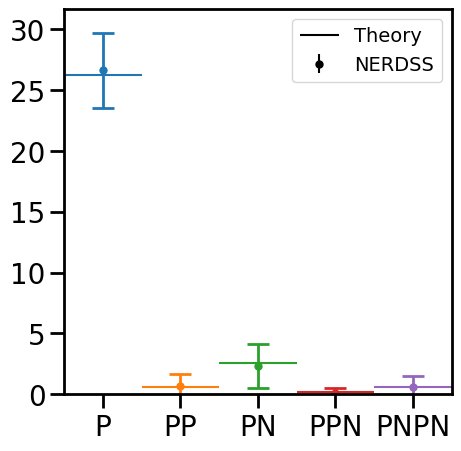

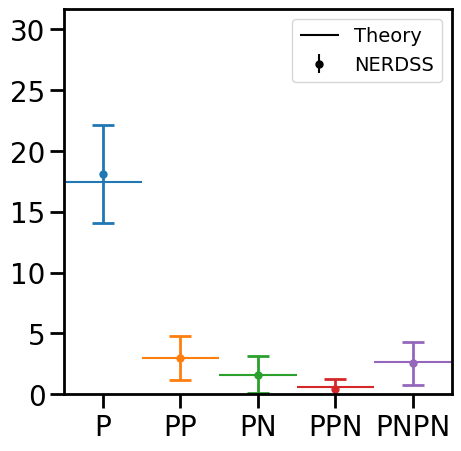

In [94]:
xpositions_nerdss = [i for i in range(len(species))]
markers = ['o', 'p', 's', '^', 'd']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
measurement_types = ['P', 'PP', 'PN', 'PPN', 'PNPN']

for i in range(len(nerdss_jobs)):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    plt.tick_params(length=10, width=2)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)  # change width
    for j in range(len(species)):
        plt.hlines(
            true_copynumbers[i][j], j-0.5, j+0.5, color=colors[j],
        )
        plt.errorbar(
            xpositions_nerdss[j], NERDSS_copynumbers[i][j], NERDSS_copynumber_errors[i][j],
            ls = '', capsize=8, color=colors[j], marker='.', markersize=10, lw=2, capthick=2
        )
    plt.errorbar(
        [], [],[], ls = '', capsize=8, color='black', marker='.', markersize=10, 
        label='NERDSS'
    )
    plt.hlines([], j-0.5, j+0.5, color='black', label='Theory')
    plt.xlim([-0.5, len(species)-0.5])
    plt.ylim([0,200 / volume / 0.6022 * 1e6])
    plt.xticks(xpositions_nerdss, measurement_types, fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=14)
    plt.show()